In [1]:
######################## Using Pytorch Only #####################

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv("../data/processed_stock_data_goog.csv")

In [3]:
# Prepare stock data
def prepare_stock_data(df, ma_periods=[5, 10, 20, 50]):
    data = df.copy()
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    for period in ma_periods:
        data[f'MA_{period}'] = data['Adj Close'].rolling(window=period).mean()
    data['Price_Change'] = data['Adj Close'].pct_change()
    data['Volume_Change'] = data['Volume'].pct_change()
    selected_features = ['Adj Close', 'Volume', 'Price_Change', 'Volume_Change', 'sentiment'] + \
                        [f'MA_{period}' for period in ma_periods]
    processed_data = data[selected_features]
    processed_data.dropna(inplace=True)
    return processed_data

df = prepare_stock_data(df)

/scratch/local/49569950/ipykernel_1188617/2596264522.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_data.dropna(inplace=True)


In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True, dropout=dropout_prob)
        self.fc1 = nn.Linear(hidden_dim * 2, 32)
        self.fc2 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc1(out[:, -1, :])
        out = self.dropout(self.relu(out))
        out = self.fc2(out)
        return out

In [5]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), :])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)


In [6]:
# Prepare and train model 
def prepare_and_train_model(df, features, sequence_length=20, test_size=0.2, learning_rate=0.001, epochs=100):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    X, y = create_sequences(scaled_data, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Convert to PyTorch tensors
    X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
    y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
    
    # Model, loss, optimizer
    input_dim = X_train.shape[2]
    model = LSTMModel(input_dim=input_dim, hidden_dim=128, layer_dim=2, output_dim=1)
    criterion = nn.HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    
    
    # Training loop with early stopping
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output.view(-1), batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Calculate average loss
        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.4f}')
    
    return model, scaler, (X_train, X_test, y_train, y_test)

In [7]:
# Evaluate predictions
def evaluate_stock_predictions(y_true, y_pred):
    y_true, y_pred = y_true.detach().numpy(), y_pred.detach().numpy()
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    results = {
        'Mean Squared Error (MSE)': mse,
        'Root Mean Squared Error (RMSE)': rmse,
        'Mean Absolute Error (MAE)': mae,
        'Mean Absolute Percentage Error (MAPE)': mape,
        'R-squared (R²)': r2
    }
    return results

In [ ]:
def save_model(model, scaler, stock, path='stock_model.pth'):
    """Save the model and scaler"""
    path 
    model_state = {
        'model_state_dict': model.state_dict(),
        'scaler': scaler
    }
    torch.save(model_state, path)

In [37]:
features = ['Adj Close', 'Volume', 'Price_Change', 'Volume_Change', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'sentiment']
model, scaler, (X_train, X_test, y_train, y_test) = prepare_and_train_model(df, features, sequence_length=24)

# Make predictions and evaluate
model.eval()
predictions = model(X_test).view(-1).detach()
results = evaluate_stock_predictions(y_test, predictions)
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

Epoch [1/100], Loss: 0.0245
Epoch [2/100], Loss: 0.0110
Epoch [3/100], Loss: 0.0081
Epoch [4/100], Loss: 0.0058
Epoch [5/100], Loss: 0.0057
Epoch [6/100], Loss: 0.0049
Epoch [7/100], Loss: 0.0047
Epoch [8/100], Loss: 0.0038
Epoch [9/100], Loss: 0.0036
Epoch [10/100], Loss: 0.0037
Epoch [11/100], Loss: 0.0034
Epoch [12/100], Loss: 0.0040
Epoch [13/100], Loss: 0.0038
Epoch [14/100], Loss: 0.0034
Epoch [15/100], Loss: 0.0036
Epoch [16/100], Loss: 0.0028
Epoch [17/100], Loss: 0.0029
Epoch [18/100], Loss: 0.0025
Epoch [19/100], Loss: 0.0021
Epoch [20/100], Loss: 0.0024
Epoch [21/100], Loss: 0.0027
Epoch [22/100], Loss: 0.0025
Epoch [23/100], Loss: 0.0027
Epoch [24/100], Loss: 0.0033
Epoch [25/100], Loss: 0.0030
Epoch [26/100], Loss: 0.0026
Epoch [27/100], Loss: 0.0023
Epoch [28/100], Loss: 0.0025
Epoch [29/100], Loss: 0.0020
Epoch [30/100], Loss: 0.0026
Epoch [31/100], Loss: 0.0024
Epoch [32/100], Loss: 0.0021
Epoch [33/100], Loss: 0.0024
Epoch [34/100], Loss: 0.0021
Epoch [35/100], Loss: 0

In [16]:
features = ['Adj Close', 'Volume', 'Price_Change', 'Volume_Change', 'MA_5', 'MA_10', 'MA_20', 'MA_50']
model, scaler, (X_train, X_test, y_train, y_test) = prepare_and_train_model(df, features, sequence_length=24)

# Make predictions and evaluate
model.eval()
predictions = model(X_test).view(-1).detach()
results = evaluate_stock_predictions(y_test, predictions)
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

Epoch [1/100], Loss: 0.0932
Epoch [2/100], Loss: 0.0214
Epoch [3/100], Loss: 0.0142
Epoch [4/100], Loss: 0.0094
Epoch [5/100], Loss: 0.0113
Epoch [6/100], Loss: 0.0085
Epoch [7/100], Loss: 0.0092
Epoch [8/100], Loss: 0.0087
Epoch [9/100], Loss: 0.0084
Epoch [10/100], Loss: 0.0090
Epoch [11/100], Loss: 0.0091
Epoch [12/100], Loss: 0.0080
Epoch [13/100], Loss: 0.0065
Epoch [14/100], Loss: 0.0082
Epoch [15/100], Loss: 0.0065
Epoch [16/100], Loss: 0.0065
Epoch [17/100], Loss: 0.0083
Epoch [18/100], Loss: 0.0073
Epoch [19/100], Loss: 0.0065
Epoch [20/100], Loss: 0.0080
Epoch [21/100], Loss: 0.0077
Epoch [22/100], Loss: 0.0065
Epoch [23/100], Loss: 0.0063
Epoch [24/100], Loss: 0.0083
Epoch [25/100], Loss: 0.0067
Epoch [26/100], Loss: 0.0068
Epoch [27/100], Loss: 0.0062
Epoch [28/100], Loss: 0.0067
Epoch [29/100], Loss: 0.0063
Epoch [30/100], Loss: 0.0066
Epoch [31/100], Loss: 0.0054
Epoch [32/100], Loss: 0.0065
Epoch [33/100], Loss: 0.0065
Epoch [34/100], Loss: 0.0066
Epoch [35/100], Loss: 0

In [ ]:
################ Feature Importance ######################

In [38]:
def calculate_permutation_importance(model, X, y, features, n_repeats=5):
    """
    Calculate permutation importance for LSTM model features
    
    Parameters:
    model: trained LSTM model
    X: input tensor
    y: target tensor
    features: list of feature names
    n_repeats: number of times to repeat permutation
    """
    model.eval()
    baseline_pred = model(X).view(-1)
    baseline_loss = torch.nn.MSELoss()(baseline_pred, y)
    
    importance_scores = []
    
    for feature_idx in range(X.shape[2]):  # Loop through each feature
        feature_importance = []
        
        for _ in range(n_repeats):
            X_permuted = X.clone()
            # Permute the feature across all sequences
            permuted_values = X_permuted[:, :, feature_idx][torch.randperm(X.shape[0])]
            X_permuted[:, :, feature_idx] = permuted_values
            
            # Calculate new loss
            with torch.no_grad():
                new_pred = model(X_permuted).view(-1)
                new_loss = torch.nn.MSELoss()(new_pred, y)
            
            # Importance is increase in loss
            importance = (new_loss - baseline_loss).item()
            feature_importance.append(importance)
        
        importance_scores.append(np.mean(feature_importance))
    
    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': importance_scores
    })
    return importance_df.sort_values('importance', ascending=False)

def calculate_integrated_gradients(model, X, features, n_steps=50):
    """
    Calculate feature importance using integrated gradients
    
    Parameters:
    model: trained LSTM model
    X: input tensor
    features: list of feature names
    n_steps: number of steps for path integral
    """
    ig = IntegratedGradients(model)
    baseline = torch.zeros_like(X)
    
    # Calculate attributions
    attributions = ig.attribute(X, baseline, n_steps=n_steps)
    
    # Average attributions across sequences and samples
    feature_importance = torch.mean(torch.abs(attributions), dim=(0, 1)).detach().numpy()
    
    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': feature_importance
    })
    return importance_df.sort_values('importance', ascending=False)


In [39]:
def plot_feature_importance(importance_df, title):
    """
    Plot feature importance results
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.title(title)
    plt.xlabel('Importance Score')
    plt.tight_layout()
    return plt

def analyze_feature_importance(model, X_test, y_test, features):
    """
    Analyze feature importance using multiple methods
    
    Parameters:
    model: trained LSTM model
    X_test: test input tensor
    y_test: test target tensor
    features: list of feature names
    """
    # Calculate permutation importance
    perm_importance = calculate_permutation_importance(model, X_test, y_test, features)
    
    # Calculate integrated gradients importance
    ig_importance = calculate_integrated_gradients(model, X_test, features)
    
    # Plot results
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.barh(perm_importance['feature'], perm_importance['importance'])
    plt.title('Permutation Importance')
    plt.xlabel('Increase in Loss')
    
    plt.subplot(1, 2, 2)
    plt.barh(ig_importance['feature'], ig_importance['importance'])
    plt.title('Integrated Gradients Importance')
    plt.xlabel('Attribution Score')
    
    plt.tight_layout()
    
    return {
        'permutation': perm_importance,
        'integrated_gradients': ig_importance
    }

def analyze_model_features(model, X_test, y_test, features):
    """
    Wrapper function to analyze feature importance for your LSTM model
    """
    # Make sure model is in evaluation mode
    model.eval()
    
    # Analyze feature importance
    importance_results = analyze_feature_importance(
        model=model,
        X_test=X_test,
        y_test=y_test,
        features=features
    )
    
    # Print results
    print("\nPermutation Importance:")
    print(importance_results['permutation'])
    print("\nIntegrated Gradients Importance:")
    print(importance_results['integrated_gradients'])
    
    return importance_results


Permutation Importance:
         feature  importance
0      Adj Close    0.003691
2   Price_Change    0.001197
4           MA_5    0.000898
3  Volume_Change    0.000013
8      sentiment    0.000010
6          MA_20   -0.000007
5          MA_10   -0.000012
1         Volume   -0.000089
7          MA_50   -0.000207

Integrated Gradients Importance:
         feature  importance
0      Adj Close    0.023612
4           MA_5    0.013212
5          MA_10    0.005543
2   Price_Change    0.005395
6          MA_20    0.002479
7          MA_50    0.001450
8      sentiment    0.000905
1         Volume    0.000734
3  Volume_Change    0.000136


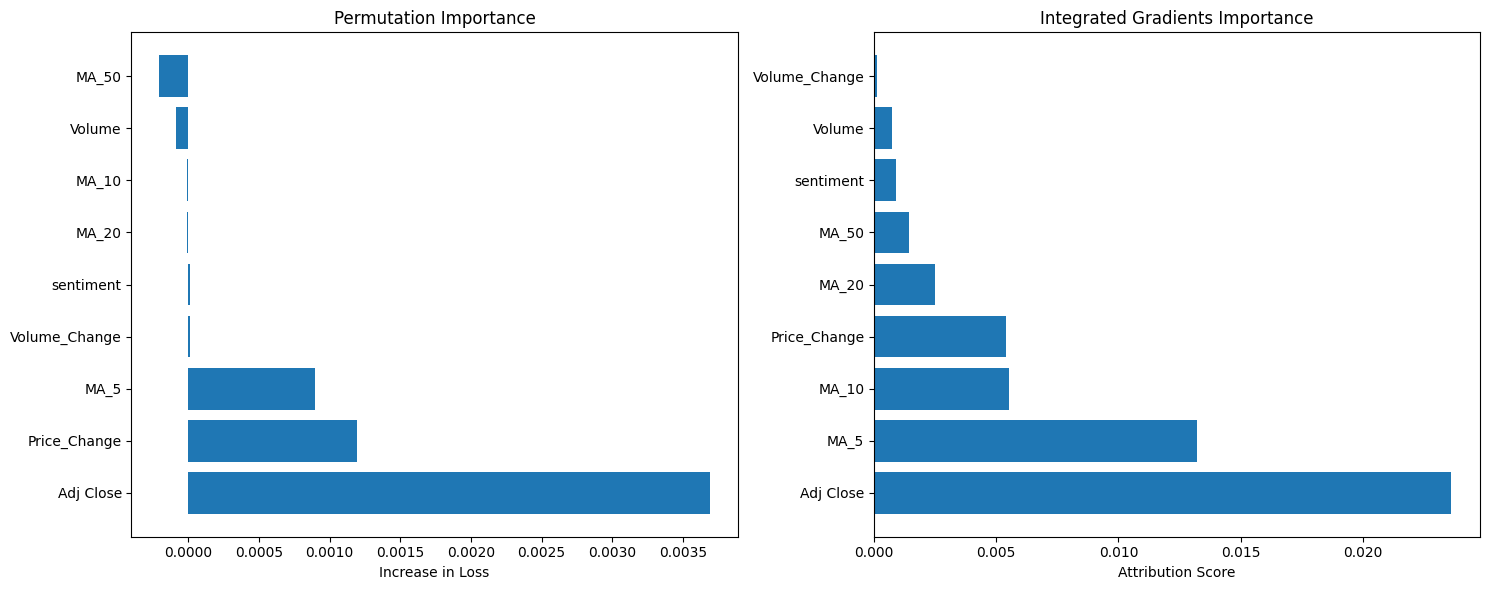

In [40]:
from captum.attr import IntegratedGradients
importance_results = analyze_model_features(model, X_test, y_test, features)

In [ ]:
#################### Walk forward Cross Validation ###########################

In [13]:
def prepare_and_train_model(df, features, sequence_length=20, n_splits=5, learning_rate=0.001, epochs=100):
    """
    Prepare and train the model using walk-forward optimization with TimeSeriesSplit
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    X, y = create_sequences(scaled_data, sequence_length)
    
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Lists to store performance metrics across folds
    fold_metrics = []
    
    # Initialize best model tracking
    best_model = None
    best_val_loss = float('inf')
    
    # Walk-forward cross-validation
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        # Split data for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Convert to PyTorch tensors
        X_train = torch.FloatTensor(X_train)
        y_train = torch.FloatTensor(y_train)
        X_val = torch.FloatTensor(X_val)
        y_val = torch.FloatTensor(y_val)
        
        # Initialize model, criterion, and optimizer
        input_dim = X_train.shape[2]
        model = LSTMModel(input_dim=input_dim, hidden_dim=128, layer_dim=2, output_dim=1)
        criterion = nn.HuberLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Create data loaders
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
        
        # Training loop for this fold
        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                output = model(batch_X)
                loss = criterion(output.view(-1), batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_predictions = []
            val_actuals = []
            
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    output = model(batch_X)
                    val_loss += criterion(output.view(-1), batch_y).item()
                    val_predictions.extend(output.view(-1).numpy())
                    val_actuals.extend(batch_y.numpy())
            
            # Calculate average losses
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            
            # Track best model based on validation loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = model.state_dict().copy()
        
        # Calculate fold metrics
        val_predictions = np.array(val_predictions)
        val_actuals = np.array(val_actuals)
        fold_results = {
            'fold': fold + 1,
            'mse': mean_squared_error(val_actuals, val_predictions),
            'rmse': np.sqrt(mean_squared_error(val_actuals, val_predictions)),
            'mae': mean_absolute_error(val_actuals, val_predictions),
            'r2': r2_score(val_actuals, val_predictions),
            'mape': np.mean(np.abs((val_actuals - val_predictions) / val_actuals)) * 100
        }
        fold_metrics.append(fold_results)
        
        print("\nFold Results:")
        for metric, value in fold_results.items():
            print(f"{metric}: {value:.4f}")
    
    # Create final model with best parameters
    final_model = LSTMModel(input_dim=input_dim, hidden_dim=128, layer_dim=2, output_dim=1)
    final_model.load_state_dict(best_model)
    
    # Calculate and print average metrics across folds
    print("\nAverage Metrics Across All Folds:")
    avg_metrics = {}
    metric_keys = ['mse', 'rmse', 'mae', 'r2', 'mape']
    for metric in metric_keys:
        avg_metrics[metric] = np.mean([fold[metric] for fold in fold_metrics])
        print(f"Average {metric.upper()}: {avg_metrics[metric]:.4f}")
    
    return final_model, scaler, fold_metrics, avg_metrics

In [14]:
features = ['Adj Close', 'Volume', 'Price_Change', 'Volume_Change', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'sentiment']
model, scaler, fold_metrics, avg_metrics = prepare_and_train_model(df, features, sequence_length=24, n_splits=5)


Fold 1/5
Epoch [1/100], Train Loss: 0.0107, Val Loss: 0.0615
Epoch [2/100], Train Loss: 0.0066, Val Loss: 0.0317
Epoch [3/100], Train Loss: 0.0071, Val Loss: 0.0315
Epoch [4/100], Train Loss: 0.0048, Val Loss: 0.0420
Epoch [5/100], Train Loss: 0.0057, Val Loss: 0.0422
Epoch [6/100], Train Loss: 0.0051, Val Loss: 0.0310
Epoch [7/100], Train Loss: 0.0037, Val Loss: 0.0090
Epoch [8/100], Train Loss: 0.0029, Val Loss: 0.0032
Epoch [9/100], Train Loss: 0.0022, Val Loss: 0.0041
Epoch [10/100], Train Loss: 0.0021, Val Loss: 0.0021
Epoch [11/100], Train Loss: 0.0021, Val Loss: 0.0034
Epoch [12/100], Train Loss: 0.0020, Val Loss: 0.0027
Epoch [13/100], Train Loss: 0.0016, Val Loss: 0.0073
Epoch [14/100], Train Loss: 0.0016, Val Loss: 0.0118
Epoch [15/100], Train Loss: 0.0018, Val Loss: 0.0076
Epoch [16/100], Train Loss: 0.0018, Val Loss: 0.0058
Epoch [17/100], Train Loss: 0.0014, Val Loss: 0.0096
Epoch [18/100], Train Loss: 0.0016, Val Loss: 0.0099
Epoch [19/100], Train Loss: 0.0012, Val Loss: